# Using the logistic encoder to represent any GGA libXC functional with just 1 parameter

Take any GGA functional from libXC (exchange and/or correlation) and represent its enhancement factor on a 2D grid (containing npoints*npoints). Then find the initial conditon $\alpha$ such that the enhancement factor can be reproduced using the logistic decoder:

$$
\begin{equation}
f(x) = \sin^2 ( 2^{x\beta} \arcsin \sqrt \alpha )
\end{equation}
$$

with $\beta$ controlling the accuracy of the encoding process (beta = 8 gives shorter parameters, but noisier interpolation. beta = 10 or above gives mostly smooth interpolations.
The accuracy of the interpolation depends on the number of grid points (npoints).

Two options are available:

1. calccorr to turn on/off the inclusion of the correlation functional (interpretation for the exchange functional is simpler, since it is only a 2-dimensional plot. See also the DFT_gga_exchange.ipynb for a similar situation without the complications of the code for the 3-dimensional fit for the correlation)
2. calcenh to divide the functional by the LDA exchange (the exact exchange for a U.E.G.). Turning this option on  gives better interpolation results, since the 2-dimensional fit is only on the enhancement factor (which is better behaved than the full xc energy density).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylibxc as pylibxc
import scipy.interpolate as spint

#Setting the most important parameters, the number of points and the functional. beta is set in helperFunctions.py
npoints=20 #very slow if going > 20
functional='gga_x_b88'
correlation='gga_c_lyp'
#include the correlation? (For correlation only, use a correlation keyword in functional)
calccorr=True
#calculate the enhancement factor? i.e. divide Fxc by Slater LDA, yes or no?
calcenh=True
#inf is a small number to avoid discontinuities at u=1 (s=infinity) and rho=0:
inf=0.000000001

In [2]:
#reading the functionals from libxc

#defining the transformation of s into u and the corresponding backtransformation    
gamma=1
uu = lambda s,g: g*(s**2+inf*s**2)/(1+g*s**2);
ss = lambda u,g: (u/(g+g*inf-g*u))**(1/2);

#select libxc functional
flda = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func = pylibxc.LibXCFunctional(functional, "unpolarized")
corr = pylibxc.LibXCFunctional(correlation, "unpolarized")

#rsrange is to restrict the range of densities when calcenh=0 to a (somehow big) number, but not=∞.
rsrange=10
fxval = []
for x in range(npoints+1): #loop over rho
    rs=(rsrange*x+inf)/npoints #rs wigner-seitz radius
    rr=(3/(rs*4*np.pi))**(1/3)/rsrange #rho
    for y in range(npoints+1): #loop over gamma
        spv=ss(y/npoints,gamma)
        gam=(rr**(4/3)*spv/(24*np.pi**2)**(-1/3))**2

        inp = {}
        inp["rho"] = [rr]
        inp["sigma"] = [gam]
    
        fval = func.compute(inp)
        lval = flda.compute(inp)
        cval = corr.compute(inp)
        zk=np.ndarray.flatten(list(fval.values())[0])
        zc=np.ndarray.flatten(list(cval.values())[0])
        zlda=np.ndarray.flatten(list(lval.values())[0])        
        if calccorr==True:
            zk=zk+zc
        if calcenh==True:
            zk = zk/zlda;
        fxval.append(zk);

#make sure that fxval fills a 1d-array
fxval=np.concatenate(fxval).ravel()

#reshape to a matrix (2d-array)
fxval3d=fxval.reshape(-1,npoints+1)

#workaround to avoid functional that diverge at s=infinity to explode at u=1. If we don't do this, the fit error will be dominated by this last point
rescale=False;
for nn in range((npoints+1)**2):
    if abs(fxval[nn])>100:
        if(fxval[nn])>0:
            fxval[nn]=5
        else:
            fxval[nn]=-5
        rescale=True
if rescale==True:
    print('Warning: This xc functional diverges at s=infinity.')
    print('Applying a patch to avoid explosion of interpolation errors') 

    

#print(fxval)
#print(fxval3d)


Applying a patch to avoid explosion of interpolation errors


In [3]:
#select one array/functional:
xxs=fxval

#normalize all data to y=[0,1] interval
from sklearn.preprocessing import MinMaxScaler

allData = np.array(xxs).reshape(-1, 1)
normalizerModel = MinMaxScaler().fit(allData)
xs = normalizerModel.transform(allData)
originalDataSize = allData.shape[0]
xs3d = xs.reshape(-1,npoints+1)

#print('alldata = %s' % xxs)
#print('alldata = %s' % xs)
#print('alldata = %s' % xs3d)

In [4]:
#Call the logistic encoder to encode data to 1 parameter (beta is set in helperFunctions and is defaulted at 8)
from helperFunctions import *

decimalInitial = findInitialCondition(xs)

#Printing the single parameter:
print(decimalInitial)
print('\nbeta = %d' % beta)
print('number of decimal digits = %d' % len(str(decimalInitial)))


significance = 5292 bits ; 1592 digits (base-10) ; ratio = 3.324

0.84829395839911714046093121313843372129171978158016367878280612656276526282004380908236141081541146087015746612873385521857947422776531865556163464559355550431365720536111861768128822649299183938720051622315679826340920031527817016953723753414476431644318647246887731490881836931007720010235320513536969324854417770339508600134591156745207127447383104148176848633059871251257299648407445349633546263698549380085550577092863982329955371626973778655625457446959510215604802472269316462778745969126746661117963025912807682760120165041601009809341759194659501408073307313557249548676511000985177491063912233575345335905268881561242034021885555284338824070286481717828805146697695325088287449954164489652350611083474802056416190135708857701737902826832748607361680031710315458242479958714305740737425894934181594840852954001896299335952314384322802147551223786301161103715758070638163125328547599878686396864131054519920308587611176935384

In [5]:
#Call the inverse transformation for decode the data
decodedValues = generateData(decimalInitial, originalDataSize)

#print('data before transformation = %s' % decodedValues)

In [6]:
#Rescale the values back to the original y range

dvR = np.array(decodedValues).reshape(-1, 1)
decodedValuesR = normalizerModel.inverse_transform(dvR)
decodedValuesR = np.concatenate(decodedValuesR).ravel()

# 3d matrices
decodedValues3d = dvR.reshape(-1,npoints+1)
decodedValuesR3d = decodedValuesR.reshape(-1,npoints+1)

#print('data after transformation = %s' % decodedValues)

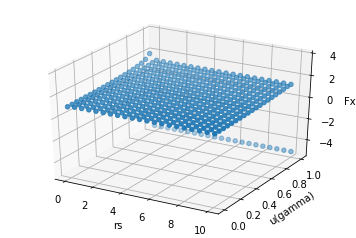

In [7]:
#plotting the original and decoded data
from mpl_toolkits.mplot3d import Axes3D


# define x and y scale 
xaxis=[] #rs before rescaling [0,1]
xaxisR=[] #rs after rescaling [0,rsrange]
for x in range(npoints+1):
    xaxis.append(x/npoints);
    xaxisR.append(rsrange*x/npoints);

yaxis=[] #gamma before rescaling [0,1]
for y in range(npoints+1):
    yaxis.append(y/npoints);
    
#inverting the axis because caonstant values of rho are in one row of the matrix (not column)
Y, X = np.meshgrid(yaxis, xaxisR)
Z = decodedValuesR3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(X, Y, Z)

ax.set_xlabel('rs')
ax.set_ylabel('u(gamma)')
ax.set_zlabel('Fxc')

if rescale == True:    
    ax.set_zlim(top=4)
plt.show()


column= 5
rs= 2.5
rho= 0.0457078


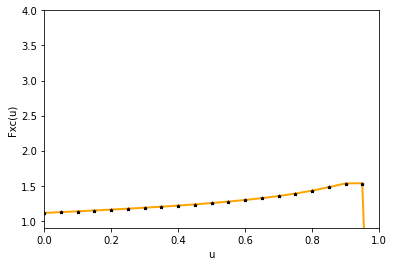

In [8]:
#plotting the original and decoded data in 1d

#selecting the value of rs at which to slice:
rsval=2.5
if rsval > rsrange:
    rsval=rsrange
ncol=rsval*npoints/rsrange
ncol=int(ncol)
if ncol==0:
    rhofromrs=1/inf
else:
    rhofromrs=(3/(xaxisR[ncol]*4*np.pi))**(1/3)/rsrange

print('column= %d' % ncol)
print('rs= %g' % xaxisR[ncol])
print('rho= %g' % rhofromrs)

#slicing the 3d plot at a certain value of rs
y1dOR=fxval3d[ncol,:]
y1dD=decodedValuesR3d[ncol,:]

plt.plot(xaxis, y1dOR, color='orange', lw=2, zorder=1)
plt.scatter(xaxis, y1dD, color='black', marker='*', s=10, zorder=2)
plt.xlabel('u', fontsize=10)
plt.ylabel('Fxc(u)', fontsize=10)    

plt.xlim(0,1)
if rescale == True:    
    plt.ylim(0.9,4)
plt.show()

-29.061985234


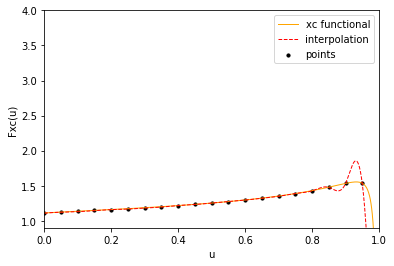

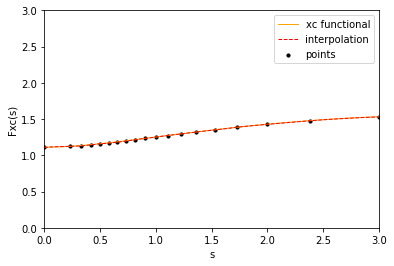


Total interpolation error = 0.488567


In [9]:
#interpolation
intrange=1000 # number of points used to evaluate the error
smoothing=0   # smoothing of the spline interpolation (pick 0 to interpolate all points)

#interpolate the functional using the npoints
gcubOV = spint.interp1d(xaxis, y1dOR, kind='cubic') # cubic spline interpolation for the libXC functional
gcub   = spint.interp1d(xaxis, y1dD, kind='cubic') # cubic spline interpolation for the decoded values
splcubOV = spint.UnivariateSpline(xaxis, y1dOR, s=smoothing) # univariate spline interpolation for the libXC functional
splcub = spint.UnivariateSpline(xaxis, y1dD, s=smoothing) # Univariate spline interpolation for the decoded values

# pick an interpolation method (splcub is the one that should be used, unless for debugging purposes):
interp=splcub

#Use libxc again to calculate the functional on a new finer grid xnew
xnew = np.linspace(0, 0.9999999,intrange)

spv=ss(xnew,gamma)
gam=(rhofromrs**(4/3)*spv/(24*np.pi**2)**(-1/3))**2
inp = {}
inp["rho"] = [rhofromrs for i in range(intrange)]
inp["sigma"] = [gam]

flda = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func = pylibxc.LibXCFunctional(functional, "unpolarized")
corr = pylibxc.LibXCFunctional(correlation, "unpolarized")

fval = func.compute(inp)
lval = flda.compute(inp)
cval = corr.compute(inp)
fk=np.ndarray.flatten(list(fval.values())[0])
fl=np.ndarray.flatten(list(lval.values())[0])
fc=np.ndarray.flatten(list(cval.values())[0])
if calccorr==True:
    fk=fk+fc
if calcenh==True:
    fk = fk/fl
if abs(fk[-1])>100:
    fk[-1]=fk[-2]*2
    print('Warning: patching functional and rescaling the plot to avoid divergence at s=infinity.')

    
print(fk[-2])
#Plot the interpolation vs the functional and the original points
plt.scatter(xaxis, y1dOR, color='black', marker='o',s=10, zorder=0,label='points')
plt.plot(xnew,fk,  color='orange', lw=1, zorder=1, label='xc functional')
plt.plot(xnew,interp(xnew), '--', color='red',lw=1, zorder=2, label='interpolation')
plt.legend(loc = 'best')
plt.xlim(0,1)
if rescale==True:
    plt.ylim(0.9,4)
plt.xlabel('u', fontsize=10)
plt.ylabel('Fxc(u)', fontsize=10)    
plt.show()

#rescaling back from u to s and replot
xaxisR=[ss(x,gamma) for x in xaxis]
xnewR=[ss(x,gamma) for x in xnew]
#reinterpolate the functional on the new range
gcubOVR = spint.interp1d(xaxisR, y1dOR, kind='cubic')
gcubR   = spint.interp1d(xaxisR, y1dD, kind='cubic')
splcubOVR = spint.UnivariateSpline(xaxisR, y1dOR, s=smoothing)
splcubR = spint.UnivariateSpline(xaxisR, y1dD, s=smoothing)

# pick an interpolation method:
interpR=splcubR

#Plot the interpolation vs the functional and the original points
plt.scatter(xaxisR, y1dOR, color='black', marker='o',s=10, zorder=0,label='points')
plt.plot(xnewR,fk,  color='orange', lw=1, zorder=1, label='xc functional')
plt.plot(xnewR,interpR(xnewR), '--', color='red',lw=1, zorder=2, label='interpolation')
plt.xlim(0,3)
plt.legend(loc = 'best')
plt.ylim(0,3)
plt.xlabel('s', fontsize=10)
plt.ylabel('Fxc(s)', fontsize=10)    
plt.show()


#Calculate the interpolation error on the finer grid
interpErr=[]
for sss in range(intrange):
    interpErr.append(abs((fk[sss] - interp((sss)/(intrange-1)))/fk[sss]))

if rescale==True:
    interpErr=interpErr[:-50] # calculate interpolation error only up to s=0.95 for ill-behaved functionals


totinterr=sum(interpErr)/npoints;




    
print('\nTotal interpolation error = %g' % totinterr)

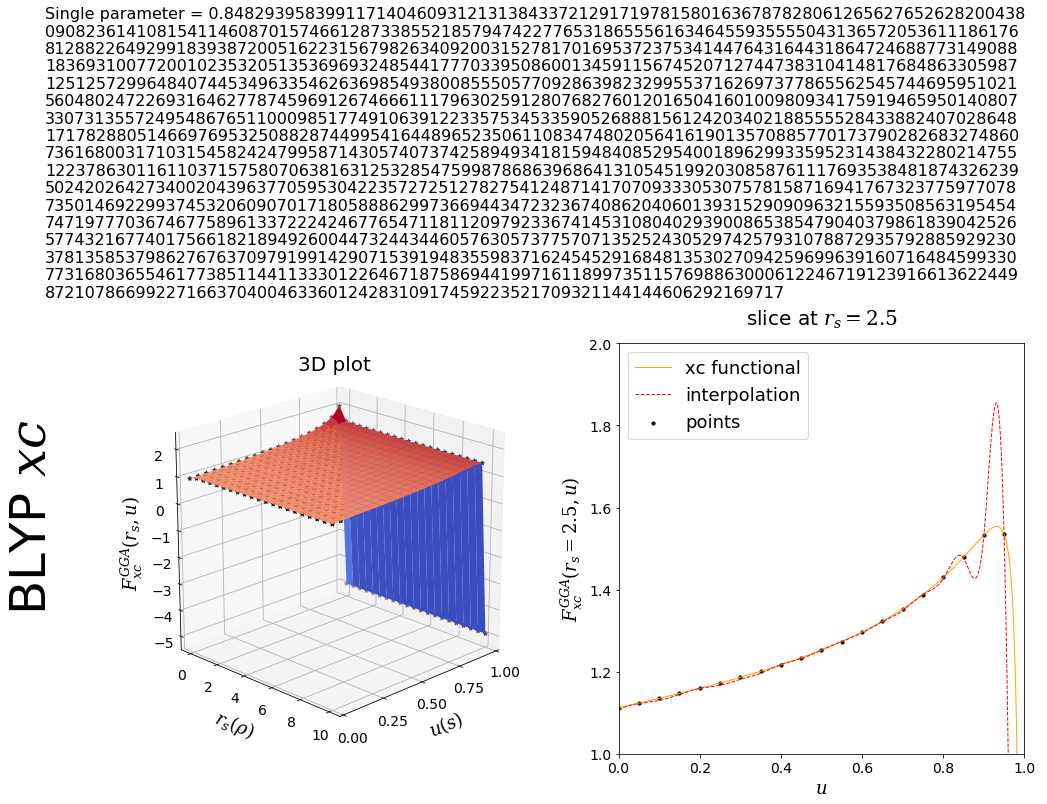

In [15]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["figure.figsize"] = [16,12]

import textwrap
fig = plt.figure()

fig.suptitle("\n".join(textwrap.wrap(str('Single parameter = {}'.format(decimalInitial)), width = 100,subsequent_indent='   ')),  x=0.05, y=0.99, ha='left', wrap=True, size=16)
fig.subplots_adjust(top=0.6)

fig.text(0.05, 0.4, "BLYP $xc$", ha='center', rotation=90, size=50, Wrap=True)


ax = fig.add_subplot(1,2,1, projection='3d')

surf = ax.scatter(X, Y, Z, color='black', marker='*')


ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')


ax.zaxis.set_rotate_label(False)
ax.view_init(20,-45)

ax.zaxis._axinfo['juggled'] = (1,2,0)

ax.set_ylabel('\n'r'$u(s)$')
ax.set_ylim(bottom=0,top=1)


ax.xaxis.set_label_coords(100, 0)

ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_xlabel('\n'r'$r_s(\rho)$')
ax.set_zlabel(r'$F_{xc}^{GGA}(r_s,u)$''\n',rotation=90)
#ax.set_zlim(bottom=0,top=4)
ax.set_title('3D plot',size=20)


#Plot the interpolation vs the functional and the original points
plt.subplot(1, 2, 2)
plt.scatter(xaxis, y1dOR, color='black', marker='o',s=10, zorder=0,label='points')
plt.plot(xnew,fk,  color='orange', lw=1, zorder=1, label='xc functional')
plt.plot(xnew,interp(xnew), '--', color='red',lw=1, zorder=2, label='interpolation')
plt.legend(loc = 'best')
plt.xlim(0,1)
if rescale==True:
    plt.ylim(1,2)
plt.title('slice at $r_s=2.5$',y=1.03,size=20)
plt.xlabel('$u$')
plt.ylabel(r'$F_{xc}^{GGA}(r_s=2.5,u)$')


#plt.savefig('GGA_BLYP_xc.png',dpi=480,bbox_inches="tight")
plt.show()



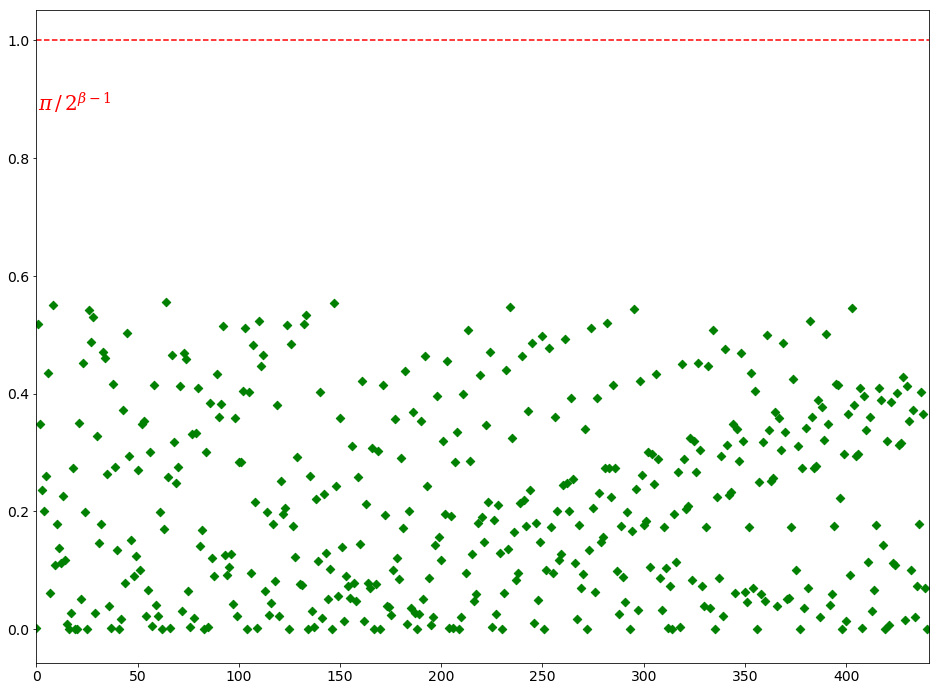

Total MaxError on the full 3D set = 4.49027


In [11]:
#Analyze the error
MaxError=np.pi/ 2 ** (beta - 1)
#MaxError=1/2**beta
#print(MaxError)

Errors = [abs(decodedValue - dataPoint)
                    for decodedValue, dataPoint in zip(decodedValues, xs)]
error=sum(Errors);
maxerror=max(Errors);
normalizedErrors = [abs(decodedValue - dataPoint)/MaxError
                    for decodedValue, dataPoint in zip(decodedValues, xs)]


xaxisforerr=[]
for x in range(len(xxs)):
    xaxisforerr.append(x);

plt.scatter(xaxisforerr, normalizedErrors, color='green', marker='D')
#plt.ylim(-0.05,20)
plt.hlines(1, 0,len(xxs), color='red', linestyle='dashed')
plt.text(0.75,0.88, r'$\pi \, / \, 2^{\beta - 1}$', fontsize=20, color='r')
plt.xlim(0,len(xxs))
plt.show()

mxaverr=sum(normalizedErrors)/len(xxs)**(1/2)
print('Total MaxError on the full 3D set = %g' % mxaverr);

In [12]:
#Final printout
#totinterr is the normalized interpolation error (normalized by the total number of points in the grid)
# this is mostly affected by the npoints parameter
totinterr=sum(interpErr)/npoints;
#totencerr is the normalized error of the encoder rescaled back to the original y range (using a pessimistic multiplication by the max value in the range, so this is really an upper bound to the error)
# this is mostly affected by the beta parameter
totencerr=sum(Errors)*max(y1dOR);
#toterr is the sum of the previous errors, which is a good indication of the success of the procedure
toterr=totinterr+totencerr;


print('Functional = %s' % functional)
if calccorr==True:
    print('Correlation = %s' % correlation)
print('Single parameter = {}'.format(decimalInitial))

if rescale == True:
    print('\nWarning: this xc functional diverges at s=infinity. The errors might be affected, even if a patch was applied! Use caution when interpreting the next results.')

print('\nnpoints = %d' % npoints)
print('Interpolation error = %g' % totinterr)
print('\nbeta = %d' % beta)
print('Encoder error = %g' % totencerr)
print('\nTotal error = %g' % toterr)

print('\nAs a rule of thumb, if the Total error printed above is < 1.0 sub-milliHartrees accuracy is achieved in a conventional KS-SCF calculation')



Functional = gga_x_b88
Correlation = gga_c_lyp
Single parameter = 0.84829395839911714046093121313843372129171978158016367878280612656276526282004380908236141081541146087015746612873385521857947422776531865556163464559355550431365720536111861768128822649299183938720051622315679826340920031527817016953723753414476431644318647246887731490881836931007720010235320513536969324854417770339508600134591156745207127447383104148176848633059871251257299648407445349633546263698549380085550577092863982329955371626973778655625457446959510215604802472269316462778745969126746661117963025912807682760120165041601009809341759194659501408073307313557249548676511000985177491063912233575345335905268881561242034021885555284338824070286481717828805146697695325088287449954164489652350611083474802056416190135708857701737902826832748607361680031710315458242479958714305740737425894934181594840852954001896299335952314384322802147551223786301161103715758070638163125328547599878686396864131054519920308587611176935384